In [70]:
import pandas as pd
import numpy as np
import bnlearn as bn
import matplotlib.pyplot as plt

In [71]:
df = pd.read_excel('exoplanets.xls')
df.head()

,radius (m),mass (kg),gravity,atmosphere,oxygene,avg_temp (C),water,rotational_period (h),life
0,11473000.0,3.478097e+25,1.80,YES,YES,35.8,YES,50.5,NO
1,10440000.0,2.620465e+25,1.64,NO,NO,34.5,NO,30.5,NO
2,12520000.0,4.518792e+25,1.96,YES,YES,42.1,YES,12.3,YES
3,11727000.0,3.714528e+25,1.84,YES,YES,39.0,NO,24.5,NO
4,7285000.0,8.903243e+24,1.14,NO,NO,9.3,NO,32.7,NO


<AxesSubplot: ylabel='Frequency'>

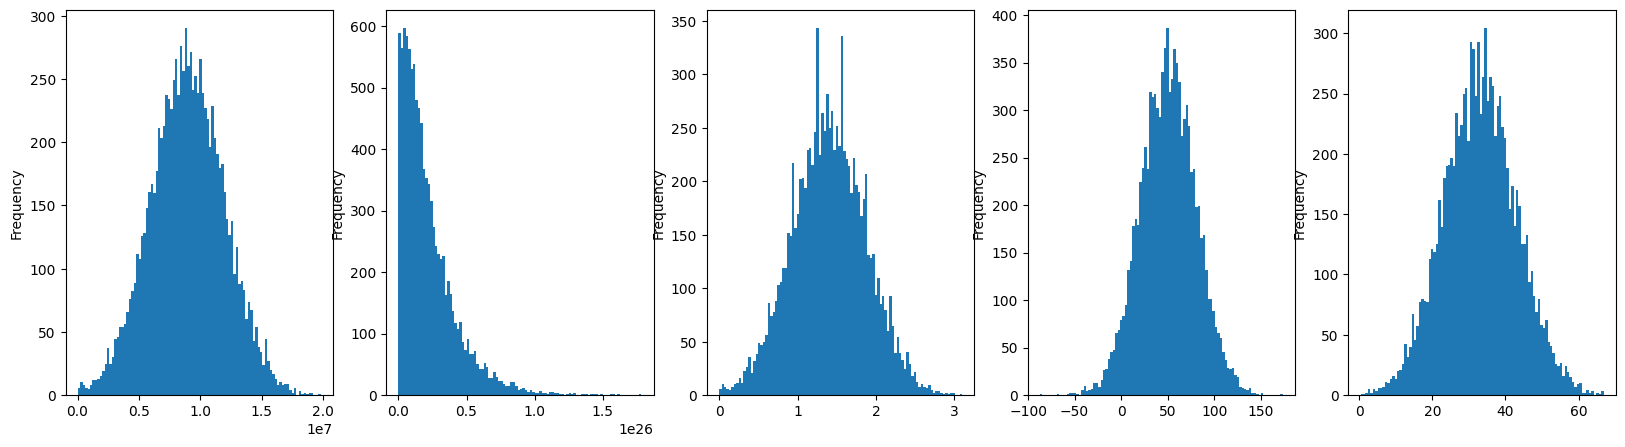

In [72]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
bins = 100
df['radius (m)'].plot.hist(bins=bins, ax=axs[0])
df['mass (kg)'].plot.hist(bins=bins, ax=axs[1])
df['gravity'].plot.hist(bins=bins, ax=axs[2])
df['avg_temp (C)'].plot.hist(bins=bins, ax=axs[3])
df['rotational_period (h)'].plot.hist(bins=bins, ax=axs[4])

In [73]:
variables = [
    ('radius (m)', 'radius'),
    ('mass (kg)', 'mass'),
    ('gravity', 'gravity'),
    ('avg_temp (C)', 'avg_temp'),
    ('rotational_period (h)', 'rotational_period'),
]

for old_name, new_name in variables:
    q1, q2, qmax = df[old_name].quantile([1/3, 2/3, 1])
    series = pd.cut(df[old_name], [0, q1, q2, qmax], labels=['small', 'medium', 'large'])
    series.name = new_name
    del df[old_name]
    df[new_name] = series

df.head()

,atmosphere,oxygene,water,life,radius,mass,gravity,avg_temp,rotational_period
0,YES,YES,YES,NO,large,large,large,small,large
1,NO,NO,NO,NO,large,large,large,small,medium
2,YES,YES,YES,YES,large,large,large,medium,small
3,YES,YES,NO,NO,large,large,large,medium,small
4,NO,NO,NO,NO,small,small,small,small,medium


In [74]:
exo_dag = bn.structure_learning.fit(df, methodtype='hc', scoretype='bic')

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Compute structure scores ['k2', 'bds', 'bic', 'bdeu'] for model comparison (higher is better).


In [75]:
print(exo_dag['adjmat'])
bn.plot(exo_dag, interactive=True)

target             atmosphere  oxygene  water   life  radius   mass  gravity  \
source                                                                         
atmosphere              False    False   True  False   False  False     True   
oxygene                  True    False  False   True   False  False    False   
water                   False    False  False   True   False  False    False   
life                    False    False  False  False   False  False    False   
radius                  False    False  False  False   False  False    False   
mass                    False    False  False  False    True  False    False   
gravity                 False    False  False  False   False   True    False   
avg_temp                False    False  False  False   False  False    False   
rotational_period       False    False  False  False   False  False    False   

target             avg_temp  rotational_period  
source                                          
atmosphere           

{'ax': '/home/aurora/uni/year_2/AI/work/two/bnlearn_causal_network.html',
 'pos': {'atmosphere': array([0.26996471, 0.06979786]),
  'oxygene': array([0.52161871, 0.27648896]),
  'water': array([0.71153994, 0.62373875]),
  'life': array([0.77706856, 0.47617978]),
  'radius': array([-0.09312653, -0.80675972]),
  'mass': array([-0.03468302, -0.51168091]),
  'gravity': array([-0.16689637, -0.48592812]),
  'avg_temp': array([-1.        ,  0.64245604]),
  'rotational_period': array([-0.98548601, -0.28429263])},
 'G': <networkx.classes.digraph.DiGraph at 0x7fda88a4a470>,
 'node_properties': {'atmosphere': {'node_color': '#1f456e', 'node_size': 10},
  'oxygene': {'node_color': '#1f456e', 'node_size': 10},
  'water': {'node_color': '#1f456e', 'node_size': 10},
  'life': {'node_color': '#1f456e', 'node_size': 10},
  'radius': {'node_color': '#1f456e', 'node_size': 10},
  'mass': {'node_color': '#1f456e', 'node_size': 10},
  'gravity': {'node_color': '#1f456e', 'node_size': 10},
  'avg_temp': {'n

In [76]:
adjmat = exo_dag['adjmat']

edges = [
  ('radius', 'mass'),
  ('mass', 'gravity'),
  ('atmosphere', 'avg_temp'),
  ('water', 'avg_temp'),
  ('gravity', 'atmosphere'),
  ('water', 'life'),
  ('oxygene', 'life'),
  ('atmosphere', 'oxygene'),
  ('avg_temp', 'life'),
]

false_edges = [
  ('atmosphere', 'mass'),
]

for (source, target) in edges:
  adjmat.loc[target, source] = False
  adjmat.loc[source, target] = True

for (source, target) in false_edges:
  adjmat.loc[target, source] = False
  adjmat.loc[source, target] = False

adjmat.fillna(False, inplace=True)
adjmat

target,atmosphere,oxygene,water,life,radius,mass,gravity,avg_temp,rotational_period
source,,,,,,,,,
atmosphere,False,True,True,False,False,False,False,True,False
oxygene,False,False,False,True,False,False,False,False,False
water,False,False,False,True,False,False,False,True,False
life,False,False,False,False,False,False,False,False,False
radius,False,False,False,False,False,True,False,False,False
mass,False,False,False,False,False,False,True,False,False
gravity,True,False,False,False,False,False,False,False,False
avg_temp,False,False,False,True,False,False,False,False,False
rotational_period,False,False,False,False,False,False,False,False,False


In [77]:
exo_dag['adjmat'] = adjmat
bn.plot(exo_dag, interactive=True)

[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


{'ax': '/home/aurora/uni/year_2/AI/work/two/bnlearn_causal_network.html',
 'pos': {'atmosphere': array([-0.10545489, -0.19952917]),
  'oxygene': array([-0.09988687, -0.30375628]),
  'water': array([ 0.06266011, -0.19449767]),
  'life': array([ 0.11345667, -0.43505844]),
  'radius': array([0.04493869, 0.24272938]),
  'mass': array([0.00345683, 0.09235848]),
  'gravity': array([-0.12528492, -0.02167685]),
  'avg_temp': array([-0.0195202 , -0.18056945]),
  'rotational_period': array([0.12563459, 1.        ])},
 'G': <networkx.classes.digraph.DiGraph at 0x7fda88a957e0>,
 'node_properties': {'atmosphere': {'node_color': '#1f456e', 'node_size': 10},
  'oxygene': {'node_color': '#1f456e', 'node_size': 10},
  'water': {'node_color': '#1f456e', 'node_size': 10},
  'life': {'node_color': '#1f456e', 'node_size': 10},
  'radius': {'node_color': '#1f456e', 'node_size': 10},
  'mass': {'node_color': '#1f456e', 'node_size': 10},
  'gravity': {'node_color': '#1f456e', 'node_size': 10},
  'avg_temp': {

In [78]:
dag_names = set(adjmat.columns)

df_names = set(df.columns)

print(dag_names)
print(df_names)
print(dag_names - df_names)

{'gravity', 'oxygene', 'radius', 'rotational_period', 'atmosphere', 'water', 'mass', 'avg_temp', 'life'}
{'gravity', 'oxygene', 'radius', 'rotational_period', 'atmosphere', 'water', 'mass', 'avg_temp', 'life'}
set()


In [79]:
exo_model = bn.parameter_learning.fit(exo_dag, df, methodtype='maximumlikelihood')

[bnlearn] >Parameter learning> Computing parameters using [maximumlikelihood]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of atmosphere:
+-----------------+-----+--------------------+
| gravity         | ... | gravity(small)     |
+-----------------+-----+--------------------+
| atmosphere(NO)  | ... | 0.7139287945034354 |
+-----------------+-----+--------------------+
| atmosphere(YES) | ... | 0.2860712054965647 |
+-----------------+-----+--------------------+
[bnlearn] >CPD of oxygene:
+--------------+----------------+---------------------+
| atmosphere   | atmosphere(NO) | atmosphere(YES)     |
+--------------+----------------+---------------------+
| oxygene(NO)  | 1.0            | 0.15010570824524314 |
+--------------+----------------+---------------------+
| oxygene(YES) | 0.0            | 0.8498942917547568  |
+--------------+----------------+---------------------+
[bnlearn] >CPD o

In [98]:
bn.inference.fit(exo_model, variables=['mass', 'avg_temp'], evidence={'life': 'YES'})

[bnlearn] >Variable Elimination..
[bnlearn] >Data is stored in [query.df]
+----+--------+------------+-----------+
|    |   mass |   avg_temp |         p |
+====+========+============+===========+
|  0 |      0 |          0 | 0.140775  |
+----+--------+------------+-----------+
|  1 |      0 |          1 | 0.158043  |
+----+--------+------------+-----------+
|  2 |      0 |          2 | 0.133528  |
+----+--------+------------+-----------+
|  3 |      1 |          0 | 0.10834   |
+----+--------+------------+-----------+
|  4 |      1 |          1 | 0.122679  |
+----+--------+------------+-----------+
|  5 |      1 |          2 | 0.10476   |
+----+--------+------------+-----------+
|  6 |      2 |          0 | 0.0734619 |
+----+--------+------------+-----------+
|  7 |      2 |          1 | 0.08463   |
+----+--------+------------+-----------+
|  8 |      2 |          2 | 0.0737829 |
+----+--------+------------+-----------+


<DiscreteFactor representing phi(mass:3, avg_temp:3) at 0x7fda88e568f0>